# Feature engineering

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from catboost import CatBoostRegressor 

from math import radians
from scipy import polyfit

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import haversine_distances
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Загрузим датасет California Housing dataset

In [4]:
california_housing = fetch_california_housing()

In [5]:
data = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
data['target'] = california_housing.target

**Описание датасета:**
Датасет содержит информацию о жилых районах штата Калифорния. 20640 Записей, 8 признаков. 

**Описание признаков:**
1. *MedInc* - медианный доход домохозяйства
2. *HouseAge* - медианный возраст домов
3. *AveRooms* - среднее число комнат
4. *AveBedrms* - среднее число спален
5. *Population* - число людей, проживающих в районе
6. *AveOccup* - среднее число людей, проживающих в доме
7. *Latitude* - широта, геогр. координаты 
8. *Longitude* - долгота, геогр. координаты

**Целевая переменная:** Медианная стоимость дома в районе, единица измерения $10 тыс.

In [6]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


В этой работе будем реализовывать различные гипотезы и тестировать их. 

Метрика качества - *mean_absolute_error*.

Разбиение на обучающую и тестовую выборку случайное.

Cтратегия кросс-валидации - ShuffledSplit.

In [7]:
def create_model():
    """
    creates CatBoostRegressor model instance
    """
    return CatBoostRegressor(random_state=RANDOM_STATE, logging_level='Silent', iterations=60)


разделим выборку на обучающую и тестовую часть

In [8]:
X = data.drop(columns=['target'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE, shuffle=True)

print('X_train size: {}, y_train size: {}'.format(X_train.shape[0], y_train.shape[0]))
print('X_test size: {}, y_test size: {}'.format(X_test.shape[0], y_test.shape[0]))


X_train size: 16512, y_train size: 16512
X_test size: 4128, y_test size: 4128


In [9]:
def add_features(X, *features):
    """
    adds new dataframes of features to X dataframe
    """
    for feature_table in features:
        for col in feature_table.columns:
            X[col] = feature_table[col]
    return X

In [10]:
def drop_features(X, features):
    """
    drops columns given in 'features' list
    """
    X = X.drop(columns=features)
    return X

Попробуем обучить модель на датасете без дополнительных признаков и преобразований. Оценим качество модели на кросс-валидации.

Разделим выборку на фолды с помошью sklearn.model_selection.KFold c параметрами:
1. n_splits = 5
2. shuffle = True
3. random_state = RANDOM_STATE

Для проведения кросс-валидации можно использовать функции cross_val_score или cross_val_predict, в которые нужно передать созданный KFold. Можно попробовать сделать кросс-валидацию с помощью самого объекта KFold.

Метрика - mean_absolute_error. Кросс-валидацию необходимо проводить на train части датасета. 

In [11]:
list(X_train.columns)

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [12]:
def cross_val(X, y, num_digits):
    """
    calculates cross validation using n_splits = 5 and shuffle = True
    """
    model = create_model()
    scoring = {'mean_absolute_error': make_scorer(mean_absolute_error)}
    kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(model, X, y, cv=kfold, scoring=scoring['mean_absolute_error'])

    return np.round(score.mean(), num_digits)

In [13]:
cross_val(X_train, y_train, 2)

0.33

В датасете есть интересные признаки - координаты районов. Координаты часто являются очень полезными, но не в исходном виде. Посмотрим, есть ли зависимость между target и расположением района.

Нарисуем диаграмму рассеивания, в которой ось x - долгота, y - широта, окрасим точки по значению target.  

[]

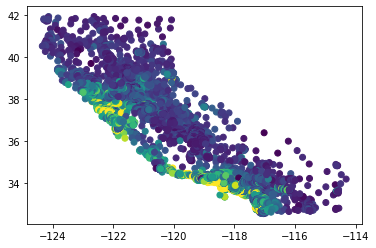

In [14]:
plt.scatter(X['Longitude'], X['Latitude'], c=y)
plt.plot()

Если сопоставить диаграмму с картой штата Калифорния, то будет видно, что цены выше у крупных городов и на побережье, попробуем добавить такой признак. Посчитаем расстояние от района до следующих крупных городов:
1. Лос-Анджелес (34.05, -118.24)
2. Сан-Хосе (37.33, -121.88)
3. Сан-Франциско (37.77, -122.41)
4. Сакраменто (38.58, -121.49)

Расстояние от каждого города до района будет отдельным признаком.

Добавим новые признаки в датасет, оценим качество на кросс-валидации как в 1 задании. В форме укажем значение метрики.

In [15]:
def dist_features(X):
    """
    calculate distances between districts and cities
    """
    cities = {'los-angeles': [34.05, -118.24], 'san-jose': [37.33, -121.88], 
              'san-francisco': [37.77, -122.41], 'sacramento': [38.58, -121.49]}
    districts = np.radians(np.array(list(zip(X['Latitude'], X['Longitude']))))
    
    dist_featrs = pd.DataFrame()
    for city, city_coords in cities.items():
        d = 6371. * haversine_distances(districts, np.radians(np.array(city_coords, ndmin=2)))
        dist_featrs[city] = list(d.reshape((d.shape[0],)))
    dist_featrs.index = X.index  
    
    return dist_featrs

In [16]:
dst_featrs_train = dist_features(X_train)

X_train = add_features(X_train, dst_featrs_train)

In [17]:
list(X_train.columns)

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'los-angeles',
 'san-jose',
 'san-francisco',
 'sacramento']

In [18]:
cross_val(X_train, y_train, 2)

0.32

Можно пойти дальше и добавить еще городов или других объектов, до которых можно посчитать расстояние, но тогда число признаков может значительно вырасти, что почти всегда приводит к плохим последствиям. Преобразуем расстояния до городов в новый категориальный признак - самый близкий город.

Построим такой признак, удалим признаки расстояний до городов и оценим качество на кросс-валидации. В форме укажем значение метрики. 

Названия городов закодируем с помощью sklearn.preprocessing.LabelEncoder.

In [19]:
X_train = drop_features(X_train, dst_featrs_train.columns)
list(X_train.columns)

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [20]:
def min_dist_city(dist_features, index):
    """
    finds the closest city to the town
    """
    LE = LabelEncoder()
    mdc_label = dist_features.idxmin(axis=1)
    mdc_to_num = pd.DataFrame({'min_dist_city': LE.fit_transform(mdc_label)})
    mdc_to_num.index = index
    
    return mdc_to_num

In [21]:
min_dist_city_train = min_dist_city(dst_featrs_train, X_train.index)
X_train = add_features(X_train, min_dist_city_train)
list(X_train.columns)

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'min_dist_city']

In [22]:
cross_val(X_train, y_train, 2)

0.33

In [23]:
X_train = drop_features(X_train, min_dist_city_train.columns)
list(X_train)

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

Попробуем добавить более сложный признак. Номер кластера, в который попадает район. Построим такой признак, оценим качество с новым признаком на кросс-валидации.

Постройте кластеризацию на всех признаках с помощью алгоритма KMeans со следующими параметрами:
1. n_clusters = 20 
2. random_state = RANDOM_STATE

Перед кластеризацией данные отмасштабируем с помощью StandardScaler. 
Масштабирование и вычисление параметров кластеризации производем на train фолдах, а применим их к train и test фолдам.

Используем все рассчитанные ранее признаки.

In [24]:
dst_featrs_test = dist_features(X_test)
min_dist_city_test = min_dist_city(dst_featrs_test, X_test.index)

X_test = add_features(X_test, dst_featrs_test, min_dist_city_test)
list(X_test.columns)

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'los-angeles',
 'san-jose',
 'san-francisco',
 'sacramento',
 'min_dist_city']

In [25]:
X_train = add_features(X_train, dst_featrs_train, min_dist_city_train)
list(X_train.columns)

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'los-angeles',
 'san-jose',
 'san-francisco',
 'sacramento',
 'min_dist_city']

In [26]:
def districts_cluster_label(X_train, X_test):
    """
    find cluster number district is in
    """
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    kmeans = KMeans(n_clusters=20, random_state=RANDOM_STATE)
    kmeans.fit(X_train_scaled)
    labels = pd.DataFrame(kmeans.predict(X_train_scaled))
    labels.index = X_train.index
    X_train['label'] = labels
    
    
    X_test_scaled = scaler.transform(X_test)
    labels = pd.DataFrame(kmeans.predict(X_test_scaled))
    labels.index = X_test.index
    X_test['label'] = labels
    
    return X_train, X_test

In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scores_on_folds = []
for train_ids, test_ids in kfold.split(X_train, y_train): #kfold будет итеративно генерировать id train и test фолдов
    
    #разделяем выборку на train и test фолды
    X_train_fold = X_train.iloc[train_ids] 
    X_test_fold = X_train.iloc[test_ids]
    y_train_fold = y_train.iloc[train_ids] 
    y_test_fold = y_train.iloc[test_ids]
    
    
    X_train_fold, X_test_fold = districts_cluster_label(X_train_fold, X_test_fold)

    Н
    model = create_model()
    model.fit(X_train_fold, y_train_fold)
    predictions = model.predict(X_test_fold)
    score = mean_absolute_error(y_test_fold, predictions)
    scores_on_folds.append(score)

print('score_by_fold: {}'.format(scores_on_folds))
print('cross-validation score: {}'.format(np.round(np.mean(scores_on_folds), 2)))

score_by_fold: [0.32280777523538984, 0.317146813726853, 0.31606913354466465, 0.3215728010967575, 0.31738549424252666]
cross-validation score: 0.32


Оценивать качество на тестовой выборке стоит только в самом конце, не важно генерируем мы новые признаки или подбираем гиперпараметры модели. Если часто смотреть на метрики на тестовой выборке и делать по ним выводы, то можно переобучиться под тест. Оценка качества на тесте получится недостоверной, по ней нельзя сделать вывод о работе модели с реальными данными. 

1. Оценим качество модели на кросс-валидации на train на всех построенных признаках.
2. Рассчитаем признаки для train и test выборок.
3. Оценим качество на test, обучившись на train.

Используем все рассчитанные раннее признаки.

In [28]:
X_train, X_test = districts_cluster_label(X_train, X_test)

In [29]:
list(X_train.columns)

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'los-angeles',
 'san-jose',
 'san-francisco',
 'sacramento',
 'min_dist_city',
 'label']

In [30]:
list(X_test.columns)

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'los-angeles',
 'san-jose',
 'san-francisco',
 'sacramento',
 'min_dist_city',
 'label']

In [31]:
cv_score = cross_val(X_train, y_train, 15)
cv_score

0.320965144460701

In [32]:
model = create_model()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
test_score = np.round(mean_absolute_error(y_test, predictions), 15)
test_score

0.320123812907942

In [33]:
np.round(test_score - cv_score, 2)

-0.0

Придумаем еще минимум 2 признака или преобразования данных, рассчитаем их и оценим качество кросс-валидации


##### Признак "Доход на человека"
Цена на дом может зависеть от того, какой доход имеет 
владелец дома. Определим классы владельцев, имеющих
низкий и высокий доходы.

In [34]:
income_per_housholder_train = pd.DataFrame(X_train['MedInc'] / X_train['AveOccup'])
kbd = KBinsDiscretizer(n_bins=2, encode='ordinal', 
                       strategy='uniform')
income_per_housholder_train = kbd.fit_transform(income_per_housholder_train)
inc_per_householder = pd.DataFrame(income_per_housholder_train)
inc_per_householder.columns = ['IncPerHouseholder']
X_train = add_features(X_train, inc_per_householder)

##### Признак "Близость к океану"
Чем ближе к океану, тем в большинстве случаев дороже дом. Определим 3 категории домов:
   0. На границе с океаном
   1. В средней части штата
   2. На границе с другим штатом

Text(0, 0.5, 'Latitude')

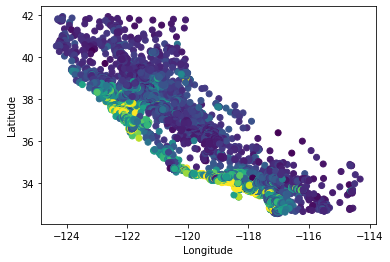

In [51]:
plt.scatter(data['Longitude'],
                data['Latitude'], 
                c=data['target'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Найдем границы, разделяющие эти три категории:
   1. Найдем приблизительную группу точек, граничащих с океаном и с другим штатом
   2. Найдем кривую второго порядка, аппроксимирующую эти точки

Text(0, 0.5, 'Latitude')

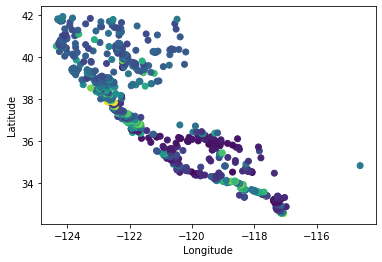

In [52]:
bottom_border = X_train.groupby('Latitude', as_index=False).agg({'Longitude': 'min'})
plt.scatter(bottom_border['Longitude'],
            bottom_border['Latitude'], 
            c=data['target'][bottom_border.index])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [53]:
def borders(X, mode):
    border = X.groupby('Latitude', as_index=False).agg({'Longitude': mode})
    coeffs = polyfit(border['Longitude'], border['Latitude'], deg=2)
    polynom = coeffs[2] + coeffs[1]*X['Longitude'] + coeffs[0]*X['Longitude']**2
    return polynom

Text(0, 0.5, 'Latitude')

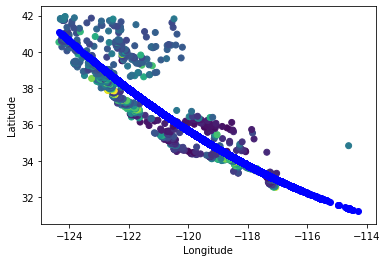

In [54]:
polynom = borders(X_train, 'min')
plt.scatter(bottom_border['Longitude'],
            bottom_border['Latitude'], 
            c=data['target'][bottom_border.index])
plt.scatter(X_train['Longitude'], polynom, c='b')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

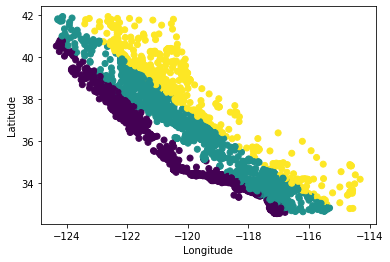

In [55]:
polynom1 = borders(X_train, 'max')
polynom2 = borders(X_train, 'min')
near_ocean = pd.DataFrame({'ocean_proximity': [0]*X_train.shape[0]})
near_ocean.index = X_train.index
near_ocean['ocean_proximity'][X_train['Latitude'] > polynom1] = 2
near_ocean['ocean_proximity'][X_train['Latitude'] < polynom2] = 0
near_ocean['ocean_proximity'][(X_train['Latitude'] < polynom1) & (X_train['Latitude'] > polynom2)] = 1
plt.scatter(X_train['Longitude'], X_train['Latitude'], c=near_ocean['ocean_proximity'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [56]:
X_train = add_features(X_train, near_ocean)

In [57]:
list(X_train.columns)

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'los-angeles',
 'san-jose',
 'san-francisco',
 'sacramento',
 'min_dist_city',
 'label',
 'IncPerHouseholder',
 'ocean_proximity']

In [58]:
cross_val(X_train, y_train, 2)

0.32